In [1]:
import torch
import torch.nn as nn
torch.set_default_dtype(torch.float64)
from collections import OrderedDict
import math
import numpy as np
import sympy as sp
import seaborn as sns
from scipy.interpolate import griddata
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from scipy.stats import qmc
import scipy.io
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/bq-soliton-rogue-residual-5-25-30000-50000points/residual_50000.npz
/kaggle/input/bq-soliton-rogue-residual-5-25-30000-50000points/residual_40000.npz
/kaggle/input/bq-soliton-rogue-residual-5-25-30000-50000points/residual_30000.npz


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
class DNN1(torch.nn.Module):
    def __init__(self, layers):
        super(DNN1, self).__init__()
        
        self.depth = len(layers) - 1
        
        # 设置激活函数
        self.activation1 = torch.nn.Tanh
        
        layer_list = list()
        for i in range(self.depth - 1): 
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            layer_list.append(('activation_%d' % i, self.activation1()))
            
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        
        # # 使用Lambda层实现 -exp(x)
        # layer_list.append(('output_activation', LambdaLayer(lambda x: -torch.exp(x))))
        
        layerDict = OrderedDict(layer_list)
        
        # 部署层
        self.layers = torch.nn.Sequential(layerDict)
        
    def forward(self, X):
        out = self.layers(X)
        return out
    
    def weights_init(m):
        if isinstance(m, (nn.Conv2d, nn.Linear)):
            nn.init.xavier_normal_(m.weight)
            nn.init.constant_(m.bias, 0.0)

class LambdaLayer(nn.Module):
    def __init__(self, lambd):
        super(LambdaLayer, self).__init__()
        self.lambd = lambd
        
    def forward(self, x):
        return self.lambd(x)


In [4]:
# the physics-guided neural network
class PINN_theta(torch.nn.Module):
    def __init__(self, X_ub,X_lb,X_ic,X_res,u_ic,v_ic,alpha,beta,gamma,layers):
        super(PINN_theta, self).__init__()
        
        # data
        self.z_ub = torch.tensor(X_ub[:, 0:1], requires_grad=True).double().to(device)
        self.t_ub = torch.tensor(X_ub[:, 1:2], requires_grad=True).double().to(device)

        self.z_lb = torch.tensor(X_lb[:, 0:1], requires_grad=True).double().to(device)
        self.t_lb = torch.tensor(X_lb[:, 1:2], requires_grad=True).double().to(device)

        self.z_ic = torch.tensor(X_ic[:, 0:1], requires_grad=True).double().to(device)
        self.t_ic = torch.tensor(X_ic[:, 1:2], requires_grad=True).double().to(device)
        self.u_ic = torch.tensor(u_ic).double().to(device)
        self.v_ic = torch.tensor(v_ic).double().to(device)

        self.z_res = torch.tensor(X_res[:, 0:1], requires_grad=True).double().to(device)
        self.t_res = torch.tensor(X_res[:, 1:2], requires_grad=True).double().to(device)

        self.alpha = torch.tensor(alpha).double().to(device)
        self.beta = torch.tensor(beta).double().to(device)
        self.gamma = torch.tensor(gamma).double().to(device)


        self.layers_theta = layers
        self.net = DNN1(layers).to(device)

        self.iter = 0
        #self.pre_iter = 0

        self.optimizer1 = torch.optim.Adam(self.net.parameters(),lr=1e-3)

        self.optimizer2 = torch.optim.LBFGS(
            self.net.parameters(), 
            lr=1.0, #步长缩放因子，用于控制拟牛顿算法中搜索的步长
            max_iter=50000, #最大迭代次数
            max_eval=50000, #函数和梯度最大评估次数
            history_size=50, #存储和更新历史信息的缓存大小
            tolerance_grad=1e-7, #表示梯度的容差，即梯度的变化小于该容差时，算法将终止
            tolerance_change=1.0 * np.finfo(float).eps, #表示优化变化的容差，即参数变化量的绝对值小于该容差时，算法将终止
            line_search_fn="strong_wolfe" #can be "strong_wolfe"
        )
        
        self.loss_history = {
            'total': [],
            'residual': [],
            'ic': [],
            'b': []
        }
    def net_h(self, z, t):  
        H = self.net(torch.cat([z, t], dim=1))
        u = H[:, 0:1]
        v = H[:, 1:2]
        return u,v
        
    def gradient(self, y, x):
        return torch.autograd.grad(y, x, grad_outputs=torch.ones_like(y), retain_graph=True, create_graph=True)[0]
    
    def net_b(self, z, t):

        u, v = self.net_h(z, t)
        u_z = self.gradient(u, z)
        v_z = self.gradient(v, z)

        return u, v, u_z, v_z          
    
    def net_ic(self, z, t):

        u, v = self.net_h(z, t)

        return u, v      
    
    def net_f(self, z, t):

        u,v = self.net_h(z, t)
        v_t = self.gradient(v, t)
        v_z = self.gradient(v, z)

        u_t = self.gradient(u, t)
        u_z = self.gradient(u, z)
        u_zz = self.gradient(u_z, z)
        u_zzz = self.gradient(u_zz, z)

        f1 = u_t - v_z
        f2 = v_t + self.alpha * u_z + self.beta * (2*u*u_z) + self.gamma * u_zzz

        return f1, f2

    def loss_func(self):

        self.optimizer1.zero_grad()
        self.optimizer2.zero_grad()

        u_ic_pred, v_ic_pred = self.net_ic(self.z_ic, self.t_ic)
        u_ub_pred, v_ub_pred, u_z_ub_pred, v_z_ub_pred = self.net_b(self.z_ub, self.t_ub)
        u_lb_pred, v_lb_pred, u_z_lb_pred, v_z_lb_pred = self.net_b(self.z_lb, self.t_lb)
        f1_res_pred, f2_res_pred = self.net_f(self.z_res, self.t_res)
    

        loss_res1 = torch.mean(f1_res_pred**2)
        loss_res2 = torch.mean(f2_res_pred**2)
        loss_res = loss_res1 + loss_res2
        loss_ic1 = torch.mean((u_ic_pred - self.u_ic)**2)
        loss_ic2 = torch.mean((v_ic_pred - self.v_ic)**2)
#         loss_b1 = torch.mean((u_ub_pred - (-11/30))**2)
#         loss_b2 = torch.mean((v_ub_pred - 0.0)**2)
#         loss_b3 = torch.mean((u_lb_pred - (-11/30))**2)
#         loss_b4 = torch.mean((v_lb_pred - 0.0)**2)
        
        loss_b1 = torch.mean((u_ub_pred - u_lb_pred)**2)
        loss_b2 = torch.mean((v_ub_pred - v_lb_pred)**2)
        loss_b3 = torch.mean((u_z_ub_pred - u_z_lb_pred)**2)
        loss_b4 = torch.mean((v_z_ub_pred - v_z_lb_pred)**2)

        loss_ic = loss_ic1 + loss_ic2
        loss_b = loss_b1 + loss_b2 + loss_b3 + loss_b4

        loss = loss_res + loss_ic1 + loss_ic2 + loss_b1 + loss_b2 + loss_b3 + loss_b4
        
        loss.backward()
        self.iter += 1
        if self.iter % 100 == 0:
            self.loss_history['total'].append(loss.item())
            self.loss_history['residual'].append(loss_res.item())
            self.loss_history['ic'].append(loss_ic.item())
            self.loss_history['b'].append(loss_b.item())     
            print(
                'Iter %d, Loss: %.5e, Loss_res: %.5e, Loss_ic1: %.5e, Loss_ic2: %.5e, Loss_b1: %.5e, Loss_b2: %.5e, Loss_b3: %.5e, Loss_b4: %.5e' % 
                (   self.iter, 
                    loss.item(), 
                    loss_res.item(), 
                    loss_ic1.item(),
                    loss_ic2.item(), 
                    loss_b1.item(),
                    loss_b2.item(),
                    loss_b3.item(),
                    loss_b4.item()
                )
            )

        return loss
    
    def train(self):
        self.net.train()
        print("采用Adam优化器")
        for i in range(20000):
            self.optimizer1.step(self.loss_func)
        # 然后运行lbfgs优化器
        print("采用L-BFGS优化器")
        self.optimizer2.step(self.loss_func) 
            
    def predict(self, X):
        
        z = torch.tensor(X[:, 0:1], requires_grad=True).double().to(device)
        t = torch.tensor(X[:, 1:2], requires_grad=True).double().to(device)

        self.net.eval()
        u,v = self.net_h(z, t)
        u = u.detach().cpu().numpy()
        v = v.detach().cpu().numpy()

        return u, v

In [5]:
alpha = -1
beta = -3
gamma = -1

x = np.linspace(-25, 25, 501)
t = np.linspace(-5, 5, 201) 
x_mesh, t_mesh = np.meshgrid(x, t)

X = np.hstack((x_mesh.flatten()[:,None], t_mesh.flatten()[:,None]))

lb = X.min(0) #下界x'QxQ
ub = X.max(0)  #上界 

df_h = np.load("/kaggle/input/bq-soliton-rogue-residual-5-25-30000-50000points/residual_50000.npz")
X_res = df_h['X_res']
X_ub = df_h['X_ub']
X_lb = df_h['X_lb']
X_ic = df_h['X_ic']

In [6]:
# alpha = -1
# beta = -3
# gamma = -1

# N_res = 1000
# N_b = 100
# N_ic = 100

# layers = [2] + 4 * [58] + [2]

# x = np.linspace(-16, 16, 201)
# t = np.linspace(-3, 3, 201) 
# x_mesh, t_mesh = np.meshgrid(x, t)

# X = np.hstack((x_mesh.flatten()[:,None], t_mesh.flatten()[:,None]))

# lb = X.min(0) #下界x'QxQ
# ub = X.max(0)  #上界 

# def lhs(n, size):
#     """生成n维拉丁超立方采样，返回size个样本点"""
#     sampler = qmc.LatinHypercube(d=n)
#     return sampler.random(n=size)

# # 使用简洁形式进行采样（与你要求的形式一致）
# X_res = lb + (ub - lb) * lhs(2, N_res)  # 2维残差点采样

# # 边界点和初始条件点也采用类似风格的简洁写法
# X_ub = np.hstack((ub[0] * np.ones((N_b, 1)), 
#                   lb[1] + (ub[1] - lb[1]) * lhs(1, N_b)))  # 上边界点

# X_lb = np.hstack((lb[0] * np.ones((N_b, 1)), 
#                   lb[1] + (ub[1] - lb[1]) * lhs(1, N_b)))  # 下边界点

# X_ic = np.hstack((lb[0] + (ub[0] - lb[0]) * lhs(1, N_ic), 
#                   lb[1] * np.ones((N_ic, 1))))  # 初始条件点

In [7]:
def func_u(X):
    x, t = X[:, 0:1], X[:, 1:2]
    alpha = -1
    beta = -3
    gamma = -1
    m = -1/5
    u = m-alpha/(2*beta)+(24*gamma*m*(-3*gamma+4*(beta**2)*(m**2)*(t**2)-2*beta*m*x**2))/((3*gamma-4*(beta**2)*(m**2)*(t**2)-2*beta*m*x**2)**2)
    v = -48*gamma*m*t*x/((-3*gamma/(2*beta*m)+2*beta*m*t**2+x**2)**2)
    return u, v

In [8]:
u_ic, v_ic = func_u(X_ic)
u_true, v_true = func_u(X)

In [9]:
#layers = [2] + 4 * [58] + [2]
layers = [2] + 6 * [45] + [2]

In [10]:
model = PINN_theta(X_ub, X_lb, X_ic, X_res, u_ic, v_ic, alpha, beta, gamma,layers)

In [11]:
def count_parameters(model):
    """计算模型中可训练参数的总个数"""
    total_params = 0
    for param in model.parameters():
        # 累加每个参数张量的元素数量
        total_params += param.numel()
    return total_params

param_count = count_parameters(model)
print(f"模型可训练参数总个数: {param_count:,}")  # 使用逗号作为千位分隔符

模型可训练参数总个数: 10,577


In [12]:
model.train()

采用Adam优化器
Iter 100, Loss: 3.15273e-04, Loss_res: 2.48001e-04, Loss_ic1: 3.34926e-05, Loss_ic2: 2.93095e-05, Loss_b1: 1.61744e-06, Loss_b2: 2.81389e-06, Loss_b3: 2.50438e-08, Loss_b4: 1.31390e-08
Iter 200, Loss: 2.62202e-04, Loss_res: 2.25756e-04, Loss_ic1: 1.76965e-05, Loss_ic2: 1.79118e-05, Loss_b1: 8.79298e-08, Loss_b2: 7.18739e-07, Loss_b3: 1.12702e-08, Loss_b4: 1.94144e-08
Iter 300, Loss: 2.29942e-04, Loss_res: 2.01909e-04, Loss_ic1: 1.36450e-05, Loss_ic2: 1.37023e-05, Loss_b1: 1.61791e-08, Loss_b2: 6.29723e-07, Loss_b3: 1.25159e-08, Loss_b4: 2.77218e-08
Iter 400, Loss: 2.06688e-04, Loss_res: 1.83751e-04, Loss_ic1: 1.11674e-05, Loss_ic2: 1.11064e-05, Loss_b1: 1.28780e-08, Loss_b2: 6.00631e-07, Loss_b3: 1.43144e-08, Loss_b4: 3.58285e-08
Iter 500, Loss: 1.93908e-04, Loss_res: 1.69404e-04, Loss_ic1: 1.29933e-05, Loss_ic2: 1.01113e-05, Loss_b1: 6.26989e-07, Loss_b2: 7.15415e-07, Loss_b3: 1.48911e-08, Loss_b4: 4.17016e-08
Iter 600, Loss: 1.79855e-04, Loss_res: 1.62096e-04, Loss_ic1: 8.8

In [13]:
u_p,v_p = model.predict(X)

In [14]:
L2 = np.linalg.norm(u_p.flatten() - u_true.flatten())/np.linalg.norm(u_true.flatten())

print (L2)

0.004607555314748581


In [15]:
L2 = np.linalg.norm(v_p.flatten() - v_true.flatten())/np.linalg.norm(v_true.flatten())

print (L2)

0.021519524024605077


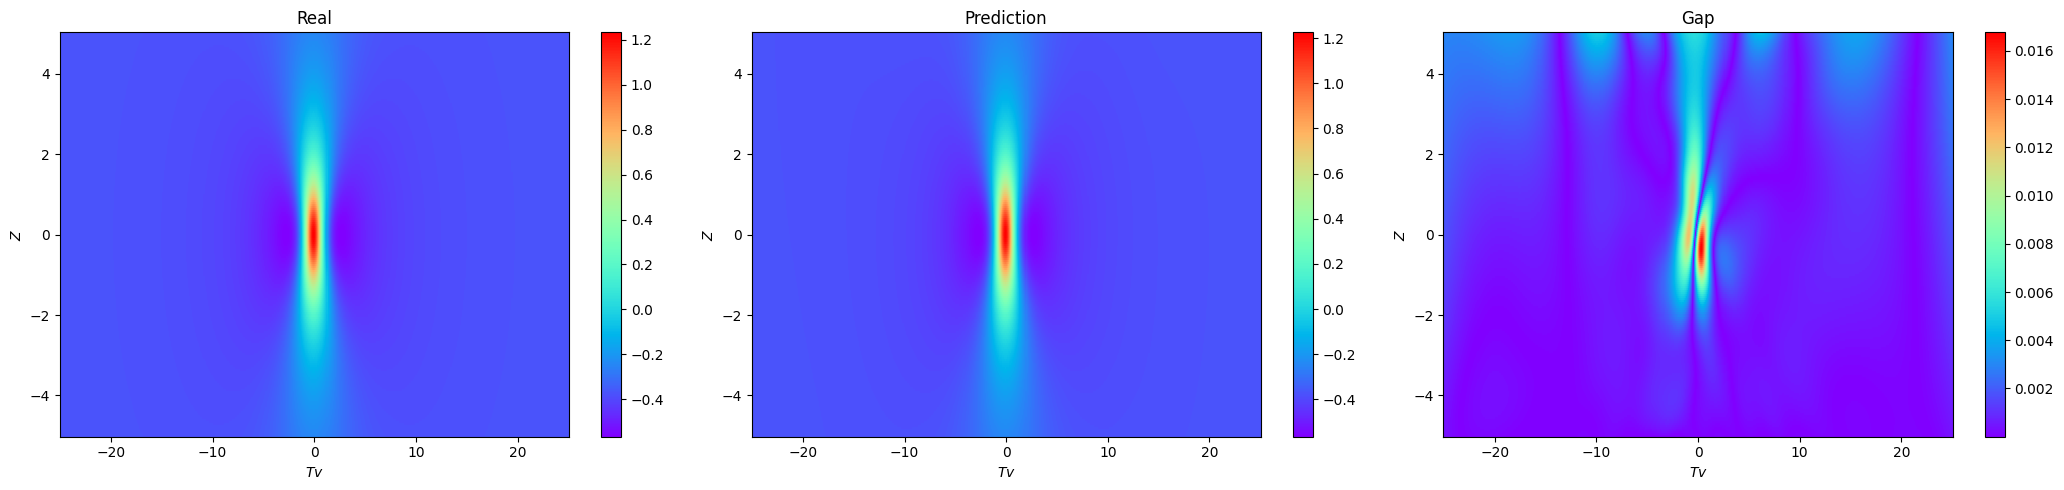

In [16]:
H_pred = griddata(X, u_p.flatten(), (x_mesh,t_mesh), method='cubic')
H_True = griddata(X, u_true.flatten(), (x_mesh,t_mesh), method='cubic')

def plot_all(T, X, H_True, H_pred):
    fig, axes = plt.subplots(1, 3, figsize=(21, 5))  # 创建1行3列的子图布局
    
    # 真实值图
    im0 = axes[0].pcolor(T, X, H_True, cmap='rainbow')
    axes[0].set_xlabel('$Tv$')
    axes[0].set_ylabel('$Z$')
    axes[0].set_title('Real')
    plt.colorbar(im0, ax=axes[0])
    
    # 预测值图
    im1 = axes[1].pcolor(T, X, H_pred, cmap='rainbow')
    axes[1].set_xlabel('$Tv$')
    axes[1].set_ylabel('$Z$')
    axes[1].set_title('Prediction')
    plt.colorbar(im1, ax=axes[1])
    
    # 差距图
    im2 = axes[2].pcolor(T, X, np.abs(H_True - H_pred), cmap='rainbow')
    axes[2].set_xlabel('$Tv$')
    axes[2].set_ylabel('$Z$')
    axes[2].set_title('Gap')
    plt.colorbar(im2, ax=axes[2])
    
    plt.tight_layout()
    plt.show()

# 调用函数绘制并排的三幅图
plot_all(x_mesh, t_mesh, H_True, H_pred)

/tmp/ipykernel_20/859717625.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('rainbow')  #


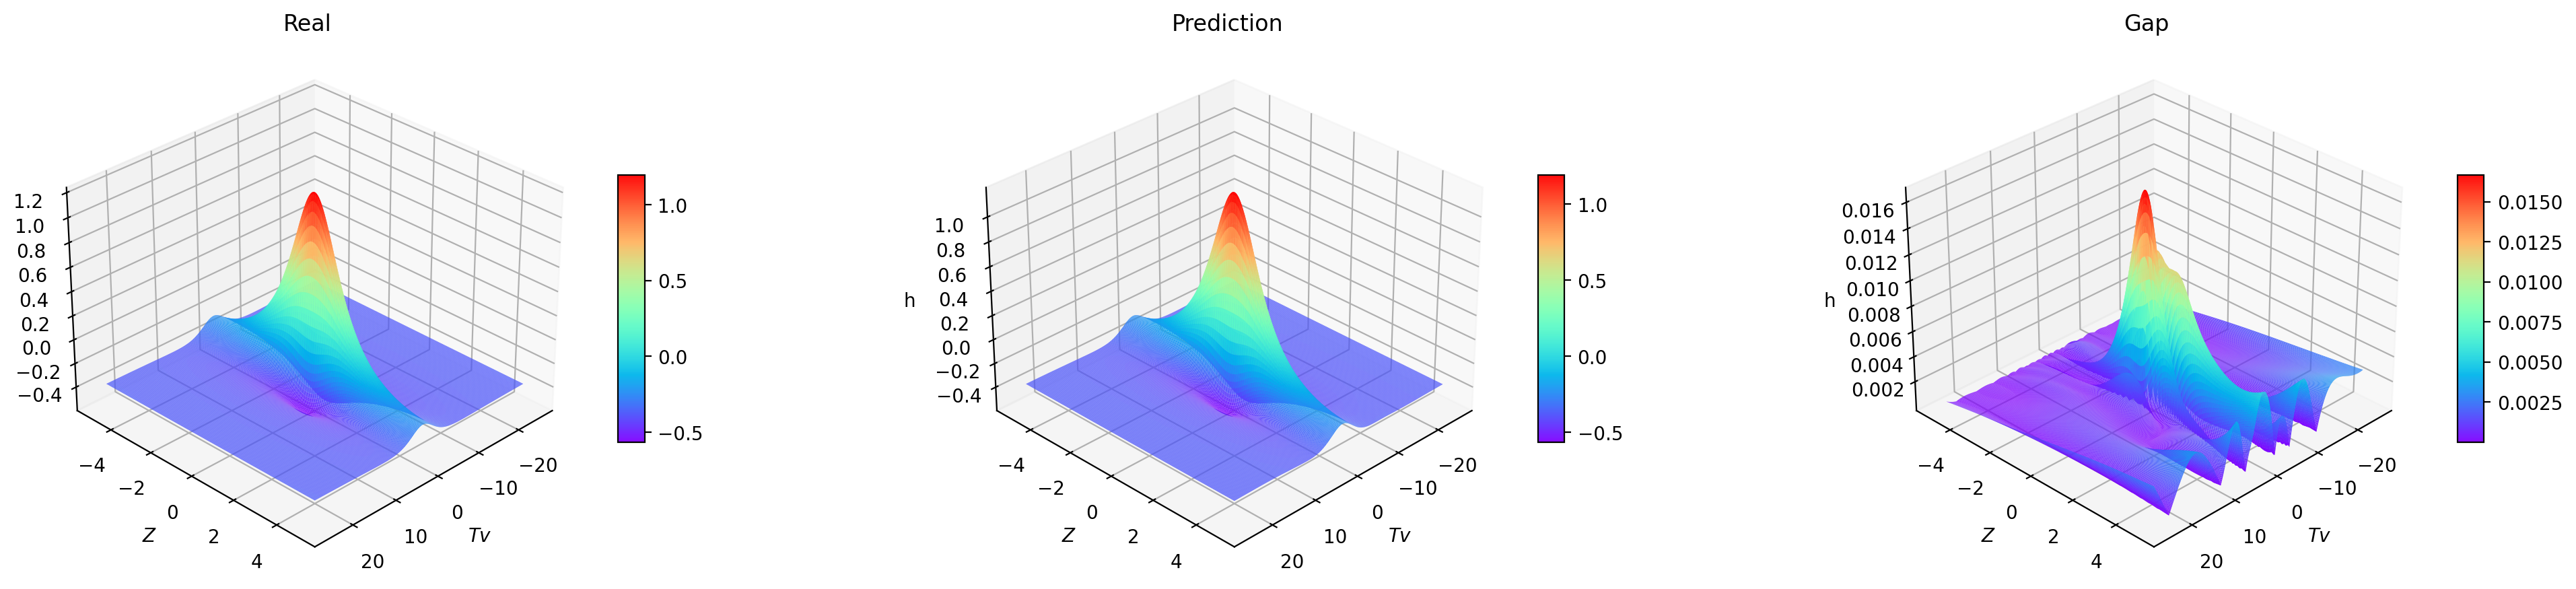

In [17]:
def plot_all_3d(T, X, H_True, H_pred, smooth_factor=1.0, dpi=150):
    """
    绘制对比3D图像（真实值、预测值和差值），并优化显示效果
    
    参数:
    - smooth_factor: 控制插值平滑程度的因子
    - dpi: 图像分辨率
    """
    # 创建更高分辨率的图形
    fig = plt.figure(figsize=(21, 5), dpi=dpi)
    
    # 定义共享的颜色映射和视角
    cmap = cm.get_cmap('rainbow')  # 
    #cmap = cm.get_cmap('viridis')  # 使用更现代的颜色映射
    elev, azim = 30, 45  # 定义共享的视角
    
    # 创建更平滑的网格数据（可选）
    if smooth_factor > 1:
        from scipy.ndimage import gaussian_filter
        H_True_smooth = gaussian_filter(H_True, sigma=smooth_factor)
        H_pred_smooth = gaussian_filter(H_pred, sigma=smooth_factor)
    else:
        H_True_smooth = H_True
        H_pred_smooth = H_pred
    
    # 计算误差
    error = np.abs(H_True - H_pred)
    
    # 定义绘图函数，减少代码重复
    def plot_surface(ax, X, Y, Z, title, cmap=cmap):
        surf = ax.plot_surface(X, Y, Z, cmap=cmap, 
                              linewidth=0, antialiased=True,
                              rstride=1, cstride=1,
                              alpha=0.95)
        ax.set_xlabel('$Tv$')
        ax.set_ylabel('$Z$')
        ax.set_zlabel('h')
        ax.set_title(title)
        ax.view_init(elev=elev, azim=azim)
        fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10, pad=0.05)
        # 添加网格线增强深度感
        ax.grid(True, linestyle='-', alpha=0.3)
        return surf
    
    # 真实值3D图
    ax0 = fig.add_subplot(131, projection='3d')
    plot_surface(ax0, T, X, H_True_smooth, 'Real')
    
    # 预测值3D图
    ax1 = fig.add_subplot(132, projection='3d')
    plot_surface(ax1, T, X, H_pred_smooth, 'Prediction')
    
    # 差距3D图
    ax2 = fig.add_subplot(133, projection='3d')
    # 使用专门的误差颜色映射
    #error_cmap = cm.get_cmap('Reds')
    plot_surface(ax2, T, X, error, 'Gap')
    
    # 调整布局，确保有足够的空间显示标签和颜色条
    plt.tight_layout(pad=3.0)
    plt.show()

# 示例调用
plot_all_3d(x_mesh, t_mesh, H_True, H_pred, smooth_factor=1.2, dpi=200)

In [18]:
pinndata = {
    'x': x_mesh.flatten()[:, None],       # x网格数据（竖排）
    't': t_mesh.flatten()[:, None],       # t网格数据（竖排）
    'h_true': u_true.flatten()[:, None],  # u真实值（竖排）
    'g_true': v_true.flatten()[:, None],  # v真实值（竖排）
    'h_pred': u_p.flatten()[:, None],     # u预测值（竖排）
    'g_pred': v_p.flatten()[:, None]      # v预测值（竖排）
}

# 保存到单个MAT文件
scipy.io.savemat('rogue_all_data.mat', pinndata)

In [19]:
loss_total = model.loss_history['total']
loss_residual = model.loss_history['residual']
loss_ic = model.loss_history['ic']
loss_b = model.loss_history['b']

In [20]:
num_iterations = len(loss_total)  # 损失记录的总数量（即总迭代次数）
iter_steps = list(range(100, 100 + num_iterations * 100, 100))
# 3. 将数据转换为竖排（列向量）：通过reshape(-1, 1)实现，形状变为(n, 1)
iter_steps_col = np.array(iter_steps).reshape(-1, 1)       # 竖排迭代步数
loss_total_col = np.array(loss_total).reshape(-1, 1)       # 竖排总损失
loss_residual_col = np.array(loss_residual).reshape(-1, 1) # 竖排残差损失
loss_ic_col = np.array(loss_ic).reshape(-1, 1)             # 竖排初始条件损失
loss_b_col = np.array(loss_b).reshape(-1, 1)               # 竖排边界条件损失

# 4. 整理并保存为mat文件（此时所有数据均为列向量）
data_loss = {
    'iter_steps': iter_steps_col,
    'loss_total': loss_total_col,
    'loss_residual': loss_residual_col,
    'loss_ic': loss_ic_col,
    'loss_b': loss_b_col
}

scipy.io.savemat('rogue_loss_history.mat', data_loss)